In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import dimod
from dimod.generators.constraints import combinations
from hybrid.reference import KerberosSampler

In [2]:
dataset = 'knots' #either 'knots' or 'summer'

In [3]:
tiles = np.load(f'data/{dataset}_tiles.npy')

In [4]:
tiles.shape

(9, 10, 10, 3)

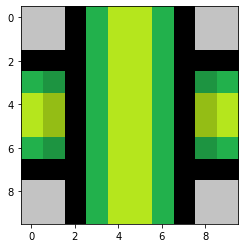

In [5]:
plt.imshow(tiles[5])
plt.show()

In [6]:
maps = np.load(f'data/{dataset}_maps.npy')

In [7]:
maps.shape

(5, 10, 10)

In [8]:
def display_image_from_tilemap(tilemap, tiles, x_dim = maps[0].shape[0], y_dim = maps[0].shape[1], tile_size=tiles[0].shape[0]):
    output_img = np.zeros((x_dim*tile_size,y_dim*tile_size,3))
    for i in range(x_dim):
        for j in range(y_dim):
            output_img[i*tile_size:i*tile_size+tile_size, j*tile_size:j*tile_size+tile_size, :] = tiles[int(tilemap[i,j])]
    fig = plt.figure(figsize = (8,8))
    ax3 = fig.add_subplot(111)
    ax3.imshow(np.uint8(output_img), interpolation='none')
    plt.show()

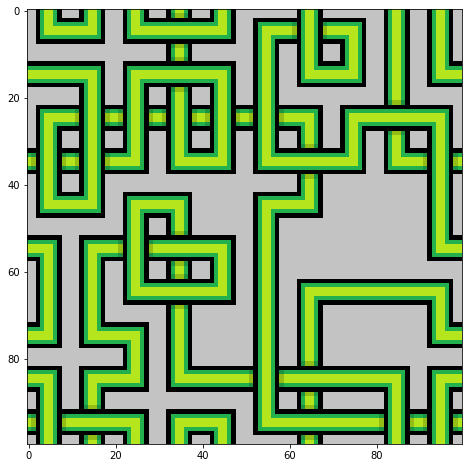

In [9]:
display_image_from_tilemap(maps[3], tiles)

In [10]:
top_allowed = set()

In [11]:
for map in maps:
    for i in range(1, len(map)):
        for j in range(len(map[i])):
            top_allowed.add((map[i][j], map[i-1][j]))

In [12]:
left_allowed = set()

In [13]:
for map in maps:
    for i in range(len(map)):
        for j in range(1, len(map[i])):
            left_allowed.add((map[i][j], map[i][j-1]))

In [14]:
all_combinations = set()

In [15]:
for i in range(len(tiles)):
    for j in range(len(tiles)):
        all_combinations.add((i,j))

In [16]:
left_not_allowed = all_combinations - left_allowed

In [17]:
top_not_allowed = all_combinations - top_allowed

In [18]:
def get_label(row, col, tile):
    return "{row},{col}_{tile}".format(**locals())

In [19]:
numTiles = tiles.shape[0]
numRows = tiles.shape[1]
numColumns = tiles.shape[2]

In [20]:
bqm = dimod.BinaryQuadraticModel({}, {}, 0.0, 'BINARY')

In [21]:
for i in range(numRows):
    for j in range(numColumns):
        for k in range(numTiles):
            bqm.add_variable(get_label(i,j,k))

In [22]:
for i in range(1,numRows):
    for j in range(numColumns):
        for k in top_not_allowed:
            bqm.add_interaction(get_label(i,j,k[0]), get_label(i-1,j,k[1]),1)

In [23]:
for i in range(numRows):
    for j in range(1,numColumns):
        for k in left_not_allowed:
            bqm.add_interaction(get_label(i,j,k[0]), get_label(i,j-1,k[1]),1)

In [24]:
for i in range(numRows):
    for j in range(numColumns):
        comb = [get_label(i,j,k) for k in range(numTiles)]
        comb_bqm = combinations(comb, 1,strength=1)
        bqm.update(comb_bqm)

In [25]:
solution = KerberosSampler().sample(bqm,
                                    max_iter=10,
                                    convergence=3,
                                    qpu_params={'label': 'Map Generation'})

In [26]:
result = solution.first.sample

In [27]:
gen_img = np.zeros(maps[0].shape)
for key in result:
    if result[key] > 0:
        coords,tile = key.split("_")
        tile = int(tile)
        x,y = coords.split(",")
        x = int(x)
        y = int(y)
        gen_img[x,y] = tile

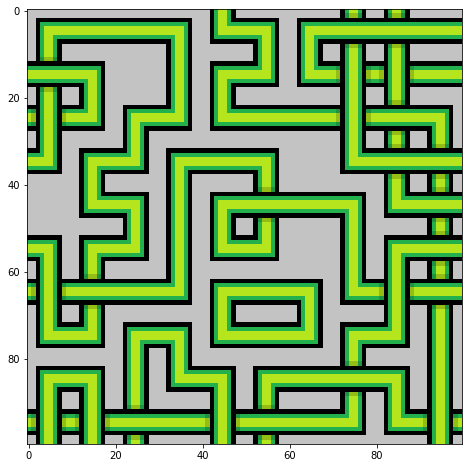

In [28]:
display_image_from_tilemap(gen_img, tiles)